In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
import sympy as sym 
import random as rand
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import qexpy as q
from scipy import integrate
from scipy.integrate import odeint

# Rungekutta - Bashford

### ¡¡PRUEBA!!

In [17]:
def System(r,t,mu=1.5):
    
    x,vx = r
    
    dxdt = vx
    dvxdt = mu*(1-x**2)*vx - x
    
    return np.array([dxdt,dvxdt])

In [18]:
t = np.linspace(0,20,10000)
r0 = [0.5,0.]

In [19]:
sol = odeint(System, r0, t, args=(1.3,))

In [24]:
def IntegratorAdams(f,r0,t,mu):
    
    h = t[1] - t[0]
    
    x = np.zeros_like(t)
    vx = np.zeros_like(t)
    
    x[0] = r0[0]
    vx[0] = r0[1]
  
    K11 = np.zeros(2)
    K12 = np.zeros(2)
    K13 = np.zeros(2)
    K14 = np.zeros(2)
    
    # Euler
    x[1] = x[0] + h*K11[0]
    vx[1] = vx[0] + h*K11[1]
    
    for i in range(1,4):
        present = np.array([x[i-1],vx[i-1]])
        K11 = f(present,t[i-1],mu)
        K12 = f(present+0.5*K11*h,t[i-1]+0.5*h,mu)
        K13 = f(present+0.5*K12*h,t[i-1]+0.5*h,mu)
        K14 = f(present+K13*h,t[i-1]+h,mu)
        x[i] = x[i-1] + h*(K11[0]+2*K12[0]+2*K13[0]+K14[0])/6
        vx[i] = vx[i-1] + h*(K11[1]+2*K12[1]+2*K13[1]+K14[1])/6


    
    
    
    xc = x.copy()
    vxc = vx.copy()
    
    for i in range(4,len(t)):
        
        present = np.array([x[i-1],vx[i-1]])
        past = np.array([x[i-2],vx[i-2]])
        past2=np.array([x[i-3],vx[i-3]])
        past3=np.array([x[i-4],vx[i-4]])
        K11 = f(present,t[i-1],mu)
        K12 = f(past,t[i-2],mu)
        K13 = f(past2,t[i-3],mu)
        K14 = f(past3,t[i-4],mu)
        
        x[i] = x[i-1] + h*(55*K11[0] - 59*K12[0] + 37*K13[0] -9*K14[0])/24
        vx[i] = vx[i-1] + h*(55*K11[1] - 59*K12[1] + 37*K13[1] -9*K14[1])/24
        
        xc[i] = x[i]
        vxc[i] = vx[i]
        
        # Futuro
        futuro = np.array([x[i],vx[i]])
        K15 = f(futuro,t[i],mu)
        
        xc[i] = xc[i-1] + h*(251*K15[0] + 646*K11[0] -264*K12[0] + 106*K13[0] - 19*K14[0])/720
        vxc[i] = vxc[i-1] + h*(251*K15[1] + 646*K11[1] -264*K12[1] + 106*K13[1] - 19*K14[1])/720
    

    
    return x,vx,xc,vxc

In [25]:

sol2 = IntegratorAdams(System,r0,t,1.3)

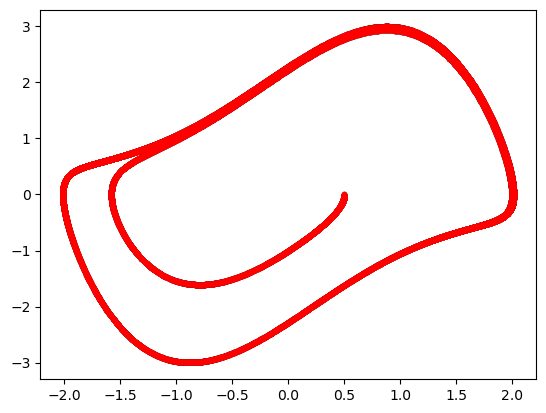

In [27]:
#plt.scatter(sol2[0],sol2[1],color='r')
plt.scatter(sol2[2],sol2[3],marker='.',color='k')
plt.scatter(sol[:,0],sol[:,1],marker='.',color="red")